The goal is to train a neural network to predict whether a parameter must be non-zero or not

In [3]:
%conda install sympy

Solving environment: done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - sympy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2022.12.7  |       ha878542_0         143 KB  conda-forge
    certifi-2022.12.7          |     pyhd8ed1ab_0         147 KB  conda-forge
    conda-4.14.0               |   py38h578d9bd_0        1012 KB  conda-forge
    mpmath-1.3.0               |     pyhd8ed1ab_0         428 KB  conda-forge
    numpy-1.20.3               |   py38h8246c76_2         5.8 MB  conda-forge
    sympy-1.11.1               |     pyh04b8f61_3         4.5 MB  conda-forge
    toolz-0.12.0               |     pyhd8ed1ab_0          48 KB  conda-forge
    ------------------------------------------------------------
                                           Total:        12.1 MB

The following NEW packages will be INSTALLED:

  mpmath  

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt

from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_fscore_support

import copy
from itertools import product
import sympy
from sympy import symbols
from time import time
import numpy as np

def round_expr(expr, num_digits):
    return expr.xreplace({n: round(n, num_digits) for n in expr.atoms(sympy.Number)})

if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
print(f'Using {device}.')

Using cpu.


## 1. Does it work for the simple polynomial model: $y=ax+b$?

In [2]:
class Net(nn.Module):
    def __init__(self, L, n_params):
        super().__init__()
        L = torch.tensor(L, dtype=torch.float)
        
        kernel_size, stride, dilation, padding = 5, 1, 1, 0
        self.conv1 = nn.Conv1d(1, 2, kernel_size=kernel_size, stride=stride, dilation=dilation, padding=padding)
        L = torch.floor((L+2*padding-dilation*(kernel_size-1)-1)/stride+1)
        
        
        kernel_size, stride, dilation, padding = 5, 1, 1, 0
        self.pool = nn.MaxPool1d(kernel_size=kernel_size, stride=stride, dilation=dilation, padding=padding)
        L = torch.floor((L+2*padding-dilation*(kernel_size-1)-1)/stride+1)
        
        print(L)
        
        self.fc1 = nn.Linear(L.int().item() * 2, 20)
        self.fc2 = nn.Linear(20, 10)
        self.fc3 = nn.Linear(10, n_params)
        
        self.softmax =  torch.nn.Softmax(dim=1)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.pool(F.relu(self.conv1(x)))
        # x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.sigmoid(self.fc3(x))
        return x

In [3]:
class MLP(nn.Module):
    def __init__(self, L, n_params):
        super().__init__()
        self.fc1 = nn.Linear(L, 50)
        self.fc2 = nn.Linear(50, n_params)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

In [4]:
a = torch.bernoulli(0.5 * torch.ones(300, 2, 1))
params = torch.randn(300, 2, 1) * a
x = torch.arange(-10, 10, 0.1).unsqueeze(0)
y = params[:, 0] + params[:, 1] * x
y_training = y[:150]
a_training = a[:150]
y_validation = y[150:200]
a_validation = a[150:200]
y_test = y[200:]
a_test = a[200:]

In [5]:
a[0:2], params[0:2]

(tensor([[[0.],
          [0.]],
 
         [[1.],
          [0.]]]),
 tensor([[[-0.0000],
          [0.0000]],
 
         [[0.7759],
          [-0.0000]]]))

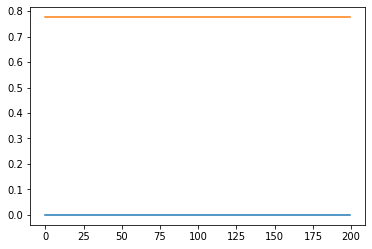

In [6]:
plt.plot(y[0:2].T)

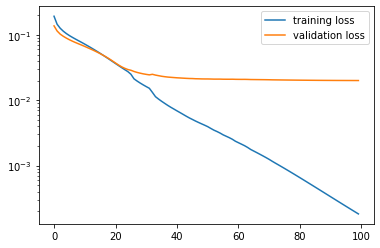

In [8]:
net = MLP(x.shape[-1], n_params=2)

# create your optimizer
optimizer = optim.Adam(net.parameters(), lr=0.0001)
criterion = nn.MSELoss()

running_loss = 0
training_loss_list = []
validation_loss_list = []
best_coeff = 0
best_loss = torch.inf

for i in range(10000):
    optimizer.zero_grad()   # zero the gradient buffers
    a_pred = net(y_training)
    loss = criterion(a_training.squeeze(2), a_pred)
    loss.backward()
    optimizer.step()  
    
    # print statistics
    running_loss += loss.item()
    if i % 100 == 99:
#        print(list(net.parameters()))
        print(f'[{i + 1:5d}] loss: {running_loss / 100:.8f}', end='\r')
        training_loss_list.append(running_loss / 100)
        running_loss = 0.0
        
        a_pred = net(y_validation)
        validation_loss = criterion(a_validation.squeeze(2), a_pred)
        validation_loss_list.append(validation_loss.cpu().detach().numpy())
        
plt.plot(training_loss_list, label='training loss')
plt.plot(validation_loss_list, label='validation loss')
plt.legend()
plt.yscale('log')

In [9]:
criterion(net(y_test), a_test.squeeze(-1))

tensor(0.0539, grad_fn=<MseLossBackward0>)

In [10]:
net(y[:5]), a[:5]

(tensor([[0.0116, 0.0113],
         [1.0000, 0.0012],
         [1.0000, 1.0000],
         [1.0000, 1.0000],
         [0.0116, 0.0113]], grad_fn=<SigmoidBackward0>),
 tensor([[[0.],
          [0.]],
 
         [[1.],
          [0.]],
 
         [[1.],
          [1.]],
 
         [[1.],
          [1.]],
 
         [[0.],
          [0.]]]))

In [11]:
a_pred = (net(y_training).detach().numpy() > 0.5).astype(int)
a_target = a_training.detach().numpy().squeeze(-1)
print(f'Precision score (training data): {precision_score(a_pred, a_target, average=None)}')
print(f'Recall score (training data): {recall_score(a_pred, a_target, average=None)}')
print(f'F1 score (training data): {f1_score(a_pred, a_target, average=None)}')

Precision score (training data): [1. 1.]
Recall score (training data): [1. 1.]
F1 score (training data): [1. 1.]


In [12]:
a_pred = (net(y_test).detach().numpy() > 0.5).astype(int)
a_target = a_test.detach().numpy().squeeze(-1)
print(f'Precision score (test data): {precision_score(a_pred, a_target, average=None)}')
print(f'Recall score (test data): {recall_score(a_pred, a_target, average=None)}')
print(f'F1 score (test data): {f1_score(a_pred, a_target, average=None)}')

Precision score (test data): [0.76       0.98214286]
Recall score (test data): [1. 1.]
F1 score (test data): [0.86363636 0.99099099]


So this works.

## 2. Does it work for general polynomials?

In [15]:
class MLP(nn.Module):
    def __init__(self, L, n_params):
        super().__init__()
        self.fc1 = nn.Linear(L, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, n_params)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))  # Yann LeCun et al. "Efficient BackProp" 1.7159 * torch.tanh(2/3*self.fc3(x))
        return x

In [493]:
dataset_size = 2000
training_set_size = 1500
a = torch.bernoulli(0.5 * torch.ones(dataset_size, 5, 1))
params = 5 * torch.randn(dataset_size, 5, 1) * a
x = torch.arange(-10, 10, 0.1).unsqueeze(0)
y = params[:, 0] + params[:, 1] * x + params[:, 2] * x**2 + params[:, 3] * x**3 + params[:, 4]*x**4
# a = 2 * a - 1
y = F.normalize(y)
y_training = y[:training_set_size]
a_training = a[:training_set_size]
y_validation = y[training_set_size:1700]
a_validation = a[training_set_size:1700]
y_test = y[1700:]
a_test = a[1700:]

In [495]:
params[0:2]

tensor([[[ 1.6730],
         [-0.0000],
         [ 0.0000],
         [ 7.8439],
         [ 1.0402]],

        [[-0.0000],
         [-0.0000],
         [-1.5122],
         [ 3.0258],
         [ 3.0923]]])

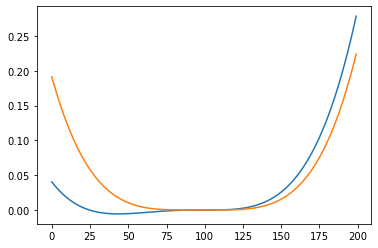

In [496]:
plt.plot(y[0:2].T)

Training took 163.2801s0


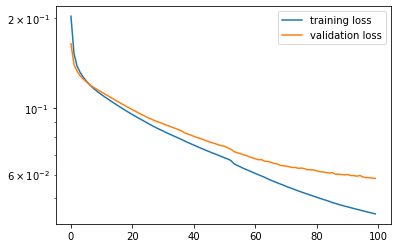

In [497]:
net = MLP(x.shape[-1], n_params=5)

# create your optimizer
optimizer = optim.Adam(net.parameters(), lr=0.0001)
criterion = nn.MSELoss()

running_loss = 0
training_loss_list = []
validation_loss_list = []
best_coeff = 0
best_loss = torch.inf

n_batches = 15
batch_size = int(training_set_size / n_batches)

t_0 = time()

for i in range(10000):
    for batch in range(n_batches):
        y_training_batch = y_training[batch * batch_size: (batch + 1) * batch_size]
        a_training_batch = a_training[batch * batch_size: (batch + 1) * batch_size]
    
        optimizer.zero_grad()   # zero the gradient buffers
        a_pred = net(y_training_batch)
        loss = criterion(a_pred, a_training_batch.squeeze(2))
        loss.backward()
        optimizer.step()  

        # print statistics
        running_loss += loss.item()
    if i % 100 == 99:
#        print(list(net.parameters()))
        print(f'[{i + 1:5d}] loss: {running_loss / 100 / n_batches:.7f}', end='\r')
        training_loss_list.append(running_loss / 100 / n_batches)
        running_loss = 0.0

        a_pred = net(y_validation)
        validation_loss = criterion(a_validation.squeeze(2), a_pred)
        validation_loss_list.append(validation_loss.cpu().detach().numpy())

t_1 = time()
print(f'Training took {t_1-t_0:.4f}s')
plt.plot(training_loss_list, label='training loss')
plt.plot(validation_loss_list, label='validation loss')
plt.legend()
plt.yscale('log')

In [498]:
net(y[:2]), a[:2], params[:2]

(tensor([[0.8955, 0.0788, 0.0986, 1.0000, 1.0000],
         [0.4306, 0.1894, 0.9038, 1.0000, 1.0000]], grad_fn=<SigmoidBackward0>),
 tensor([[[1.],
          [0.],
          [0.],
          [1.],
          [1.]],
 
         [[0.],
          [0.],
          [1.],
          [1.],
          [1.]]]),
 tensor([[[ 1.6730],
          [-0.0000],
          [ 0.0000],
          [ 7.8439],
          [ 1.0402]],
 
         [[-0.0000],
          [-0.0000],
          [-1.5122],
          [ 3.0258],
          [ 3.0923]]]))

In [499]:
criterion(net(y_test), a_test.squeeze(-1))

tensor(0.0534, grad_fn=<MseLossBackward0>)

In [500]:
a_pred = (net(y_training).detach().numpy() > 0.5).astype(int)
# a_target = (a_training.detach().numpy().squeeze(-1) + 1) / 2
a_target = a_training.detach().numpy().squeeze(-1)
average = 'micro' 
print(f'Precision score (training data): {precision_score(a_target, a_pred, average=average)}')
print(f'Recall score (training data): {recall_score(a_target, a_pred, average=average)}')
print(f'F1 score (training data): {f1_score(a_target, a_pred, average=average)}')

Precision score (training data): 0.9706221198156681
Recall score (training data): 0.9046979865771813
F1 score (training data): 0.9365013199944421


In [501]:
a_pred = (net(y_test).detach().numpy() > 0.5).astype(int)
# a_target = (a_training.detach().numpy().squeeze(-1) + 1) / 2
a_target = a_test.detach().numpy().squeeze(-1)
print(f'Precision score (test data): {precision_score(a_target, a_pred, average=average)}')
print(f'Recall score (test data): {recall_score(a_target, a_pred, average=average)}')
print(f'F1 score (test data): {f1_score(a_target, a_pred, average=average)}')

Precision score (test data): 0.9340974212034384
Recall score (test data): 0.8798920377867746
F1 score (test data): 0.906184850590688


## 3. Does it work for more complicated functions? $y=\cos(ax)b+c+\cos(dx)^2e$

In [22]:
class MLP(nn.Module):
    def __init__(self, L, n_params):
        super().__init__()
        self.fc1 = nn.Linear(L, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, n_params)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))  # Yann LeCun et al. "Efficient BackProp" 1.7159 * torch.tanh(2/3*self.fc3(x))
        return x

In [22]:
dataset_size = 25000
training_set_size = 23500
validation_set_size = 500 
a = torch.bernoulli(0.7 * torch.ones(dataset_size, 5, 1))
a[:, 0] = a[:, 0] * a[:, 1]
a[:, 1] = a[:, 0] * a[:, 1]
a[:, 3] = a[:, 3] * a[:, 4]
a[:, 4] = a[:, 3] * a[:, 4]
params = 5 * torch.randn(dataset_size, 5, 1) * a
x = torch.arange(-10, 10, 0.1).unsqueeze(0)
y = torch.cos(params[:, 0]*x)* params[:, 1] + params[:, 2] + torch.cos(params[:, 3]*x)**2*params[:,4]
# a = 2 * a - 1
y = F.normalize(y)
y_training = y[:training_set_size]
a_training = a[:training_set_size]
y_validation = y[training_set_size:training_set_size+validation_set_size]
a_validation = a[training_set_size:training_set_size+validation_set_size]
y_test = y[training_set_size+validation_set_size:]
a_test = a[training_set_size+validation_set_size:]

In [23]:
y.shape, a.shape

(torch.Size([25000, 200]), torch.Size([25000, 5, 1]))

In [50]:
params[0:2]

tensor([[[  0.0000],
         [  0.0000],
         [  0.0000],
         [-10.3139],
         [ -4.6188]],

        [[  0.2310],
         [  6.0663],
         [ -1.5729],
         [  0.0000],
         [ -0.0000]]])

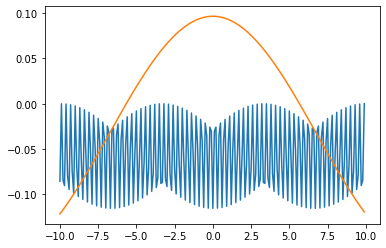

In [51]:
plt.plot(x.squeeze(0), y[0:2].T)

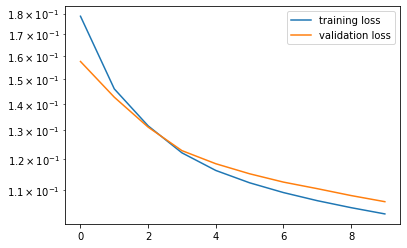

In [52]:
net = MLP(x.shape[-1], n_params=5)

# create your optimizer
optimizer = optim.Adam(net.parameters(), lr=0.0001)
criterion = nn.MSELoss()

running_loss = 0
training_loss_list = []
validation_loss_list = []
best_coeff = 0
best_loss = torch.inf

n_batches = 30
batch_size = int(training_set_size / n_batches)

t_0 = time()

for i in range(1000):
    permutation = np.random.permutation(training_set_size)
    y_training_permute = y_training[permutation]
    a_training_permute = a_training[permutation]
    
    for batch in range(n_batches):
        y_training_batch = y_training_permute[batch * batch_size: (batch + 1) * batch_size]
        a_training_batch = a_training_permute[batch * batch_size: (batch + 1) * batch_size]
    
        optimizer.zero_grad()   # zero the gradient buffers
        a_pred = net(y_training_batch)
        loss = criterion(a_pred, a_training_batch.squeeze(2))
        loss.backward()
        optimizer.step()  

        # print statistics
        running_loss += loss.item()
    if i % 100 == 99:
#        print(list(net.parameters()))
        a_pred = net(y_validation)
        validation_loss = criterion(a_validation.squeeze(2), a_pred)
        validation_loss_list.append(validation_loss.cpu().detach().numpy())
        print(f'[{i + 1:5d}] Training loss: {running_loss / 100 / n_batches:.8f}, Validation loss: {validation_loss:.8f}', end='\r')
        training_loss_list.append(running_loss / 100 / n_batches)
        running_loss = 0.0


t_1 = time()
plt.plot(training_loss_list, label='training loss')
plt.plot(validation_loss_list, label='validation loss')
plt.legend()
plt.yscale('log')

In [53]:
print(f'Training took {t_1-t_0:.4f}s')

Training took 72.8742s


In [54]:
net(y[:2]), a[:2], params[:2]

(tensor([[0.0602, 0.0595, 0.2520, 0.9906, 0.9904],
         [0.9952, 0.9949, 0.5465, 0.2088, 0.2149]], grad_fn=<SigmoidBackward0>),
 tensor([[[0.],
          [0.],
          [0.],
          [1.],
          [1.]],
 
         [[1.],
          [1.],
          [1.],
          [0.],
          [0.]]]),
 tensor([[[  0.0000],
          [  0.0000],
          [  0.0000],
          [-10.3139],
          [ -4.6188]],
 
         [[  0.2310],
          [  6.0663],
          [ -1.5729],
          [  0.0000],
          [ -0.0000]]]))

In [55]:
criterion(net(y_test), a_test.squeeze(-1))

tensor(0.1142, grad_fn=<MseLossBackward0>)

In [56]:
a_pred = (net(y_training).detach().numpy() > 0.5).astype(int)
# a_target = (a_training.detach().numpy().squeeze(-1) + 1) / 2
a_target = a_training.detach().numpy().squeeze(-1)
average = 'micro' 
print(f'Precision score (training data): {precision_score(a_target, a_pred, average=average)}')
print(f'Recall score (training data): {recall_score(a_target, a_pred, average=average)}')
print(f'F1 score (training data): {f1_score(a_target, a_pred, average=average)}')

Precision score (training data): 0.8392609286151367
Recall score (training data): 0.9032688137498996
F1 score (training data): 0.8700892788067277


In [57]:
a_pred = (net(y_test).detach().numpy() > 0.5).astype(int)
# a_target = (a_training.detach().numpy().squeeze(-1) + 1) / 2
a_target = a_test.detach().numpy().squeeze(-1)
print(f'Precision score (test data): {precision_score(a_target, a_pred, average=average)}')
print(f'Recall score (test data): {recall_score(a_target, a_pred, average=average)}')
print(f'F1 score (test data): {f1_score(a_target, a_pred, average=average)}')

Precision score (test data): 0.8278716798896171
Recall score (test data): 0.8928571428571429
F1 score (test data): 0.8591372829783427


## 3. Does it work for ParFamNP?

In [2]:
import os
os.getcwd()

'/home/math/scholl/projects/physicalLawLearning/ForNet/ParFamNP/optimization/trainingOnSyntheticData'

In [3]:
%cd '..'
%cd '..'
os.getcwd()

/home/math/scholl/projects/physicalLawLearning/ForNet/ParFamNP/optimization
/home/math/scholl/projects/physicalLawLearning/ForNet/ParFamNP


'/home/math/scholl/projects/physicalLawLearning/ForNet/ParFamNP'

In [4]:
from parfam_np import ParFamNP, Evaluator

In [5]:
class MLP(nn.Module):
    def __init__(self, L, n_params):
        super().__init__()
        self.fc1 = nn.Linear(L, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, n_params)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))  # Yann LeCun et al. "Efficient BackProp" 1.7159 * torch.tanh(2/3*self.fc3(x))
        return x

In [6]:
# Without batch_prediction the data generation for 10**6 data points took 420s

In [184]:
torch.save(a, f'data_sets/a_dataset_size_{dataset_size}_d_input_{degree_input_polynomials}_d_output_{degree_output_polynomials}_width_{width}.pt')
torch.save(y, f'data_sets/y_dataset_size_{dataset_size}_d_input_{degree_input_polynomials}_d_output_{degree_output_polynomials}_width_{width}.pt')

In [190]:
a_new = torch.load(f'data_sets/a_dataset_size_{dataset_size}_d_input_{degree_input_polynomials}_d_output_{degree_output_polynomials}_width_{width}.pt')
y_new = torch.load(f'data_sets/y_dataset_size_{dataset_size}_d_input_{degree_input_polynomials}_d_output_{degree_output_polynomials}_width_{width}.pt')

In [11]:
x = np.arange(-10, 10, 0.1)
x = x.reshape(len(x), 1)
functions = [np.sin, np.cos]
function_names = [sympy.sin, sympy.cos]
degree_input_polynomials = 2
degree_output_polynomials = 2
width = 1
target_model = ParFamNP(n_input=1, degree_input_polynomials=degree_input_polynomials, degree_output_polynomials=degree_output_polynomials, width=width,
                        functions=functions, function_names=function_names)
n_params = target_model.get_number_parameters()

dataset_size = 12000
training_set_size = 1000
validation_set_size = 1000

In [12]:
x = np.arange(-10, 10, 0.1).reshape(-1, 1)
y = np.zeros((dataset_size, len(x)))
a = np.zeros((dataset_size, n_params))
params = torch.randn(dataset_size, n_params)

t_0 = time()



for i in range(dataset_size):
    a[i] = target_model.get_random_coefficients(n_functions_max=3)

params = params * a
y = target_model.predict_batch(params.T, x).T

#    params[i] = params[i] * a[i]
#    y[i] = target_model.predict(params[i], x)
a = torch.tensor(a, dtype=torch.float, device=device).unsqueeze(-1)
y = torch.tensor(y, dtype=torch.float, device=device)
y = F.normalize(y)
t_1 = time()
print(f'Generating the data took {t_1 - t_0:.3f}s.')

y_training = y[:training_set_size]
a_training = a[:training_set_size]
y_validation = y[training_set_size:training_set_size+validation_set_size]
a_validation = a[training_set_size:training_set_size+validation_set_size]
y_test = y[training_set_size+validation_set_size:]
a_test = a[training_set_size+validation_set_size:]

Generating the data took 2.006s.


In [13]:
y.shape, a.shape, params.shape

(torch.Size([12000, 200]), torch.Size([12000, 16, 1]), torch.Size([12000, 16]))

In [47]:
params[0:2]

tensor([[ 0.8123,  0.7742,  0.0000, -1.1044, -0.0000,  2.0328,  0.0000,  1.2073,
          0.0000,  0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0450,  0.0000],
        [-0.2502,  0.0462, -0.0000,  1.0043, -0.0000,  1.5027, -0.0000, -0.0000,
         -0.0000,  0.0000,  0.1134,  0.0000,  0.0000, -0.0000, -0.0000,  0.0000]],
       dtype=torch.float64)

Computing the formula for the input layer took 0.009 seconds
Computing the end formula took 0.008 seconds
Simplifying the formula took 0.000 seconds
Target expression 0: -0.045*x0*sin(0.774*x0 + 0.812) + 1.207*cos(2.033*x0**2 - 1.104)
Computing the formula for the input layer took 0.008 seconds
Computing the end formula took 0.007 seconds
Simplifying the formula took 0.000 seconds
Target expression 1: 0.113*sin(0.046*x0 - 0.25)*cos(1.503*x0**2 + 1.004)


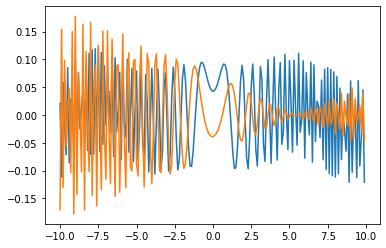

In [48]:
x_sym = symbols('x')

target_expr = target_model.get_formula(params[0])
target_expr = round_expr(target_expr, 3)
print(f'Target expression 0: {target_expr}')

target_expr = target_model.get_formula(params[1])
target_expr = round_expr(target_expr, 3)
print(f'Target expression 1: {target_expr}')

plt.plot(x.squeeze(1), y[0:2].squeeze(-1).cpu().T)

In [49]:
# how should we adapt the loss function such that the ambivalences are being taken care of?

In [50]:
x.shape

(200, 1)

In [ ]:
net = MLP(x.shape[0], n_params=n_params).to(device)

# create your optimizer
optimizer = optim.Adam(net.parameters(), lr=0.0001)
criterion = nn.MSELoss()

running_loss = 0
training_loss_list = []
validation_loss_list = []
best_coeff = 0
best_loss = torch.inf

n_batches = 100
batch_size = int(training_set_size / n_batches)
print(f'Batch size: {batch_size}')
t_0 = time()

for i in range(5000):
    permutation = np.random.permutation(training_set_size)
    y_training_permute = y_training[permutation]
    a_training_permute = a_training[permutation]
    
    for batch in range(n_batches):
        y_training_batch = y_training_permute[batch * batch_size: (batch + 1) * batch_size]
        a_training_batch = a_training_permute[batch * batch_size: (batch + 1) * batch_size]
    
        optimizer.zero_grad()   # zero the gradient buffers
        a_pred = net(y_training_batch)
        loss = criterion(a_pred, a_training_batch.squeeze(2))
        loss.backward()
        optimizer.step()  

        # print statistics
        running_loss += loss.item()
    if i % 100 == 99:
#        print(list(net.parameters()))
        a_pred = net(y_validation)
        validation_loss = criterion(a_validation.squeeze(2), a_pred)
        validation_loss_list.append(validation_loss.cpu().detach().numpy())
        print(f'[{i + 1:5d}] Training loss: {running_loss / 100 / n_batches:.8f}, Validation loss: {validation_loss:.8f}', end='\r')
        training_loss_list.append(running_loss / 100 / n_batches)
        running_loss = 0.0


t_1 = time()
plt.plot(training_loss_list, label='training loss')
plt.plot(validation_loss_list, label='validation loss')
plt.legend()
plt.yscale('log')

Batch size: 9900


In [194]:
torch.save(net, f'models/model_dataset_size_{dataset_size}_d_input_{degree_input_polynomials}_d_output_{degree_output_polynomials}_width_{width}.pt')

In [10]:
net = torch.load(f'models/model_dataset_size_{dataset_size}_d_input_{degree_input_polynomials}_d_output_{degree_output_polynomials}_width_{width}.pt', map_location=torch.device(device))

In [36]:
print(f'Training took {t_1-t_0:.4f}s')

Training took 39.5577s


In [37]:
net(y[:2]), a[:2], params[:2]

(tensor([[7.5162e-01, 7.3592e-01, 2.0735e-01, 2.4662e-01, 3.0567e-01, 2.8080e-01,
          7.4663e-01, 3.9886e-02, 4.3370e-01, 3.9350e-02, 1.5489e-02, 7.6284e-01,
          9.7777e-01, 9.5552e-03, 4.8527e-05, 3.5375e-04],
         [8.9725e-05, 5.9537e-04, 6.5179e-02, 9.8742e-01, 9.7591e-01, 9.3627e-01,
          1.4560e-02, 1.2624e-01, 2.9472e-01, 3.3925e-02, 3.2732e-03, 1.6457e-04,
          1.0157e-03, 8.5810e-01, 1.4137e-01, 1.1447e-03]], device='cuda:0',
        grad_fn=<SigmoidBackward0>),
 tensor([[[1.],
          [1.],
          [0.],
          [1.],
          [0.],
          [1.],
          [0.],
          [0.],
          [1.],
          [0.],
          [0.],
          [1.],
          [1.],
          [0.],
          [0.],
          [0.]],
 
         [[0.],
          [0.],
          [0.],
          [1.],
          [1.],
          [1.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [1.],
          [0.],


In [15]:
criterion = nn.MSELoss()
criterion(net(y_test), a_test.squeeze(-1))

tensor(0.1060, grad_fn=<MseLossBackward0>)

In [39]:
a_pred = (net(y_training).cpu().detach().numpy() > 0.5).astype(int)
# a_target = (a_training.detach().numpy().squeeze(-1) + 1) / 2
a_target = a_training.cpu().detach().numpy().squeeze(-1)
average = 'micro' 
print(f'Precision score (training data): {precision_score(a_target, a_pred, average=average)}')
print(f'Recall score (training data): {recall_score(a_target, a_pred, average=average)}')
print(f'F1 score (training data): {f1_score(a_target, a_pred, average=average)}')

Precision score (training data): 0.9430985915492958
Recall score (training data): 0.744
F1 score (training data): 0.8318012422360248


In [17]:
a_pred = (net(y_test).cpu().detach().numpy() > 0.5).astype(int)
# a_target = (a_training.detach().numpy().squeeze(-1) + 1) / 2
a_target = a_test.cpu().detach().numpy().squeeze(-1)
average = 'micro'
print(f'Precision score (test data): {precision_score(a_target, a_pred, average=average)}')
print(f'Recall score (test data): {recall_score(a_target, a_pred, average=average)}')
print(f'F1 score (test data): {f1_score(a_target, a_pred, average=average)}')

Precision score (test data): 0.7285219174070097
Recall score (test data): 0.6810020305263398
F1 score (test data): 0.703960944777897
